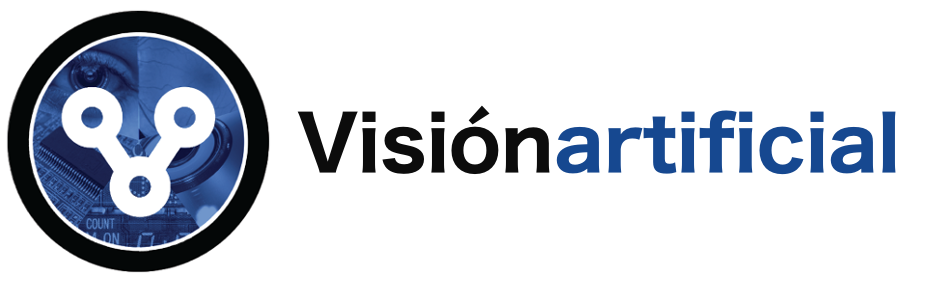

# OpenCV 

### para a materia de Visión Artificial do Grao de Robótica. EPSE de Lugo.

<hr style = "border: none; height: 4px; background-color: # D3D3D3" />


# 1. Segmentación


## 1.1 Técnicas baseadas en contornos para a segmentación de imaxes

A segmentación de imaxes é o proceso de **asignar unha etiqueta a cada píxel dunha imaxe** para que os píxeles que compartan certas características tamén compartan a etiqueta (clase). Como consecuencia, produce rexións cuxos píxeles teñen propiedades similares (*p. ex.* intensidade, cor, textura ou localización na imaxe) que teñen un significado xeométrico e semántico (ver Fig.1). O resultado da segmentación da imaxe pode ser:
- un conxunto de segmentos que cobren colectivamente toda a imaxe (por exemplo, limiar),
- ou un conxunto de contornos extraídos da imaxe (por exemplo, detección de bordos).

<figure style="text-align:center">
  <img src="./imgs/image-segmentation-example.png" width="550">
  <center><figcaption>Fig. 1: Exemplo de segmentación de imaxes onde cada rexión corresponde a un obxecto da escena.</figcaption></center>
</figure>

Conceptualmente, existen dous enfoques tradicionais para a segmentación de imaxes (ver figura 2):
- **Segmentación de top-down**, que considera que os píxeles do mesmo obxecto da escena deben estar na mesma rexión segmentada.
- **Segmentación bottom-up**, que establece que os píxeles similares da imaxe deben estar na mesma rexión segmentada. $\\[5pt]$

<figure style="text-align:center">
  <img img src="./imgs/bottom-up_top-down-segmentation.png" width="500">
  <center><figcaption>Fig. 2. Un exemplo de enfoques de top-down e bottom-up.</figcaption></center>
</figure>

Poñemos o foco aquí nos enfoques de segmentación bottom-up. Os métodos que seguen este enfoque pódense agrupar en:
- **Técnicas baseadas en contornos**, que tentan identificar as rexións da imaxe detectando os seus contornos.
- **Técnicas baseadas na rexión** que agrupan píxeles que son similares.


Neste caderno imos experimentar ambas as dúas, comezando por **técnicas baseadas en contornos**, que se concentran en detectar contornos específicos na imaxe (por exemplo, círculos). Neste contexto, os contornos da imaxe defínense como píxeles de borde que encerran unha rexión.

As técnicas baseadas en contornos pódense clasificar aproximadamente en:
- **Técnicas locais.** Intentan segmentar rexións detectando contornos pechados, que normalmente encerran píxeles con intensidades similares.
   - LoG + cruce por cero.
   - Seguimento de bordes (operador Canny).
   - Contornos activos (snakes)
   - Random walker
- **Técnicas globais.** Detectar determinadas formas na imaxe (círculos, liñas, etc.).
   - Transformación de Hough.
   
Este caderno non cubriremos as técnicas de **contornos** nin a **Transformada de Hough** posto que xa que foi tratados en temas anteriores. Non obstante, si que abordaremos un exemplo de contornos activos empregando a libraría de sckit-learn.

### 1.1.1 Contornos activos (snakes)

Para esta sección, utilizaremos unha imaxe dunha persoa en primeiro plano e tentaremos segmentar a parte da cabeza mediante a técnica de contornos deformables. 
A segmentación activa do contorno, tamén chamada "snakes", inicialízase mediante un contorno ou liña definido polo usuario, ao redor da área de interese e este contorno se contrae lentamente atraído ou repelido por unha función potencial constitida, xeralmente, por intensidade e bordes.
Para a nosa imaxe de exemplo, debuxemos un círculo arredor da cabeza da persoa para inicializar a snake.

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20.0,20.0)
matplotlib.rcParams['image.cmap'] = 'gray'

%matplotlib inline

In [3]:
import skimage.data as data


from skimage.color import rgb2gray
from skimage.filters import gaussian
from skimage.segmentation import active_contour

In [4]:
def image_show(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 14))
    ax.imshow(image, cmap='gray');
    ax.axis('off')
    return fig, ax

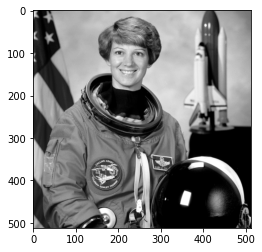

In [5]:
imagePath = "./imgs/girl.jpg"
image = cv2.imread(imagePath,0)
if image is None:
    raise Exception("Non atopo a imaxe no sitio indicado")

    
image = data.astronaut()
image = rgb2gray(image)

#Visualizamos a imaxe orixinal    
plt.figure()
plt.imshow(image);

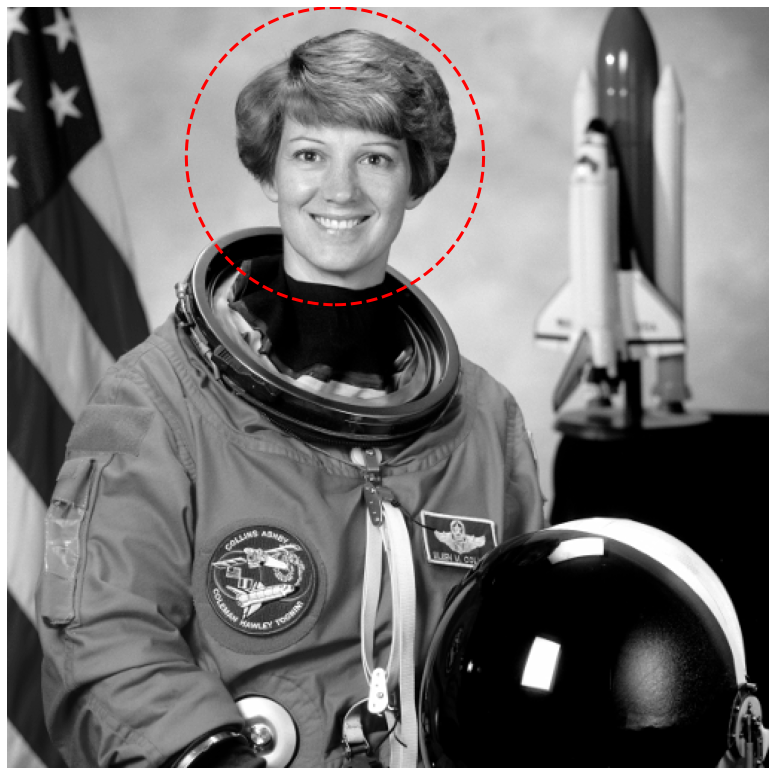

In [6]:
def circle_points(resolution, center, radius):
    """
    Xeramos os puntos para debuxar un circulo na imaxe
    """
    radians = np.linspace(0, 2*np.pi, resolution)

    c = center[0] + radius*np.cos(radians)
    r = center[1] + radius*np.sin(radians)
    
    return np.array([c, r]).T

# Excluimos un punto para non duplicar o mesmo punto (inicio e fin son coincidentes)
points = circle_points(400, [100, 220], 100)[:-1]  #x e y OLLO: non fila x columna
fig, ax = image_show(image)
ax.plot(points[:, 1], points[:, 0], '--r', lw=3);

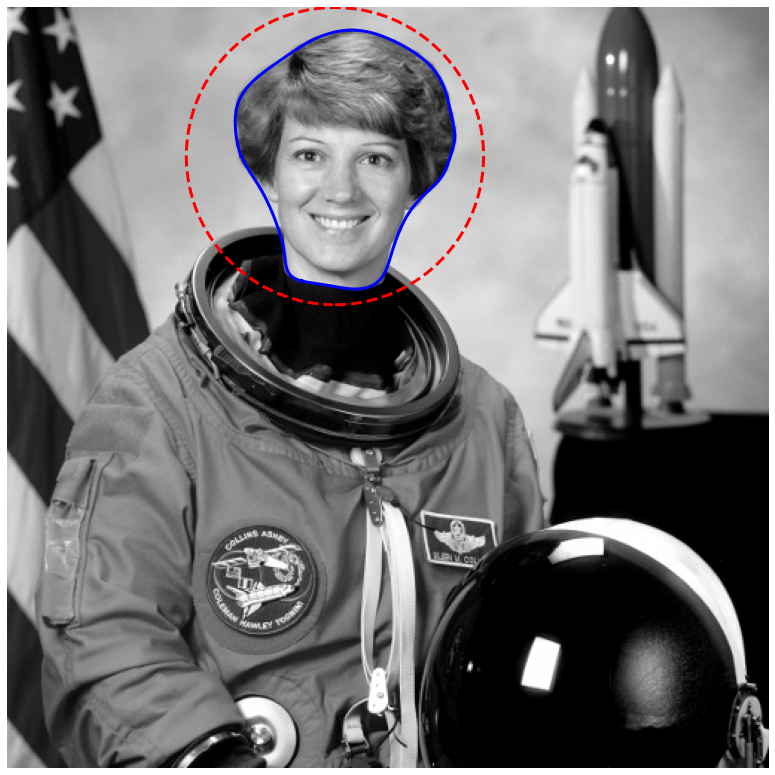

In [7]:
# Despois, o algoritmo segmenta a cara dunha persoa 
# a partir do resto dunha imaxe axustando unha curva pechada aos bordos da cara.

snake = active_contour(gaussian(image, 3, preserve_range=False),
                       points, alpha=0.01, beta=1.5, gamma=0.004)


fig, ax = image_show(image)
ax.plot(points[:, 1], points[:, 0], '--r', lw=3)
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3);

### 1.1.2 A técnica de Ramdon walker

Neste método, un usuario especifica de forma interactiva un pequeno número de píxeles que se coñecen como etiquetas. Imaxínate que cada píxel sen etiquetar libera un camiñante aleatorio quee cunha determinada probabilidade de que comece en cada píxel sen etiqueta e chegue a un dos píxeles preetiquetados. Ao asignar cada píxel á etiqueta para a que se calcula a maior probabilidade, pódese obter unha segmentación de imaxe de alta calidade. 

Reutilizaremos aquí os valores de semente do noso exemplo anterior. Poderiamos ter fixo diferentes inicializacións, pero por simplicidade imos nos círculos.

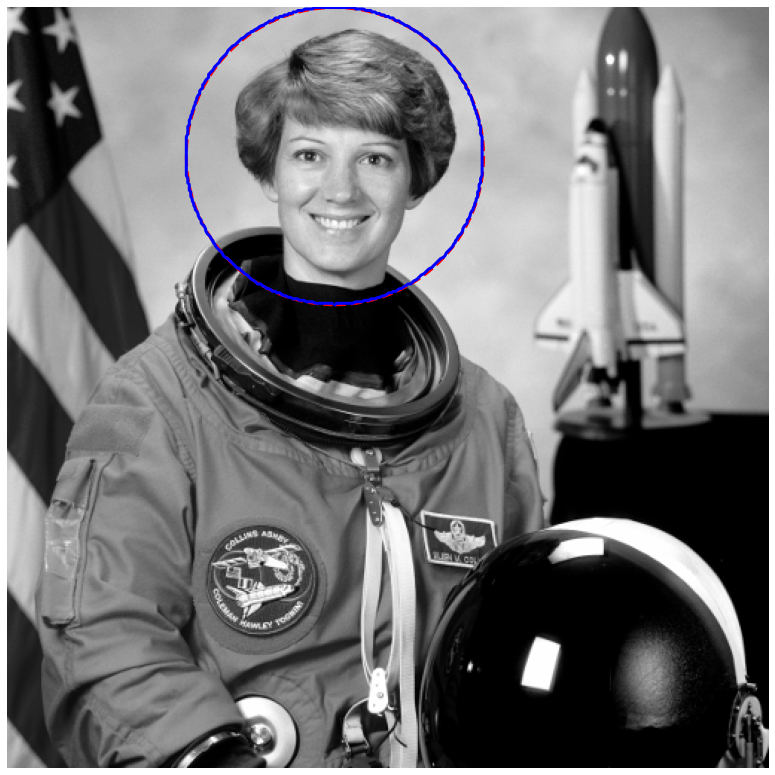

In [8]:
import skimage.draw as draw
#O algoritmo do camiñante aleatorio espera unha imaxe etiquetada como entrada. 
#Polo tanto, teremos o círculo máis grande que abarca toda a cara da persoa e 
#outro máis pequeno preto do medio da cara.
image_labels = np.zeros(image.shape, dtype=np.uint8)
indices = draw.circle_perimeter(100, 220,20) #dende aqui [100, 220], 100
image_labels[indices] = 1
image_labels[points[:, 0].astype(np.int), points[:, 1].astype(np.int)] = 2

fig, ax = image_show(image)
ax.plot(points[:, 1], points[:, 0], '--r', lw=3)
ax.plot(points[:, 1].astype(np.int), points[:, 0].astype(np.int), '-b', lw=3);



/tmp/ipykernel_4986/223407763.py:4: UserWarning: The probability range is outside [0, 1] given the tolerance `prob_tol`. Consider decreasing `beta` and/or decreasing `tol`.
  image_segmented = seg.random_walker(image, image_labels,beta=0.01, mode='cg_j')


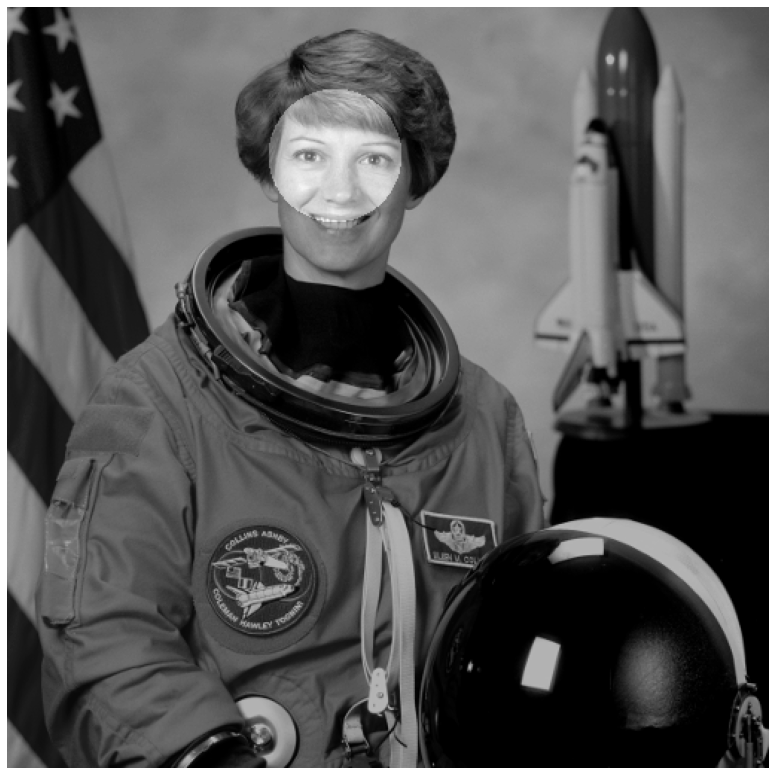

In [16]:
import skimage.segmentation as seg

#https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.random_walker
image_segmented = seg.random_walker(image, image_labels,beta=0.01, mode='cg_j')

# Visualizacion
fig, ax = image_show(image)
ax.imshow(image_segmented == 1, alpha=0.3);

# 1.2 Segmentación de rexións coherentes


<br/>
<figure>
    <img src="imgs/L941.png" width=400/>
    <img src="imgs/L942.png" width=400/>
    <center><figcaption>Fig 1(a): <a href="https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/">Base de datos para segmentación de Berkeley</a> </figcaption></center>
</figure>


### Segmentación figura-fondo

- Separa o obxecto en primeiro plano (figura) do fondo da imaxe

<br/>
<figure>
    <img src="imgs/L943.png" width=400/>
    <center><figcaption>Fig 1(b)</figcaption></center>
</figure>

### Agrupación de veciños semellantes


<br/>
<figure>
    <img src="imgs/L944.png" width=400/>
    <center><figcaption>Fig 1(c): Superpíxeles</figcaption></center>
</figure>

### Máis aló de imaxes individuais ...

<br/>
<figure>
    <img src="imgs/L945.png" width=400/>
    <center><figcaption>Fig 1(d)</figcaption></center>
</figure>

## Imaxe ruidosa

### Segmentación de imaxes: exemplo sintético

<br/>
<figure>
    <img src="imgs/L946.png" width=400/>
    <center><figcaption>Fig 2(a)</figcaption></center>
</figure>

<br/>
<figure>
    <img src="imgs/L947.png" width=400/>
    <center><figcaption>Fig 2(b): con ruído</figcaption></center>
</figure>


Como determinar as tres intensidades principais que definen os nosos grupos?

- Necesitamos **un clustereing**.

## Clustering (agrupación)

- Obxectivo: escoller tres valores ("centros") como intensidades **representativas** de cada obxecto (clase) e logo etiquetamos cada píxel da imaxe segundo a súa proximidade aos centros representativos.


<br/>
<figure>
    <img src="imgs/L948.png" width=400/>
    <img src="imgs/L949.png" width=400/>
    <center><figcaption>Fig 3(a)</figcaption></center>
</figure>

- Os mellores centros para o clustering son aqueles que **minimizan a distancia SSD** entre todos os puntos e o centro máis próximo $c_i$:

$$\color{blue}{SSD = \sum_{cluster\, C_i}\sum_{p \in C_i}||P_j - c_i||^2}$$

O problema do clustering podemos velo como o dilema do "ovo e a galiña": primeiro, se coñezo os centroides, como determino a pertenencia de cada píxel ao cluster e, dous, se coñezo a pertencia dos pixels a cada cluster como determino os centros de cada clase. Vexamos:

- obxectivo 1: 
     - P: Se coñecemos $c_i$, como determinaríamos que puntos asociamos con cada **centro de clúster**?
     - R: para cada punto p, escollemos o centroide **máis próximo** $c_i$    
    
<br/>
<figure>
    <img src="imgs/L950.png" width=400/>
    <center><figcaption>Fig 3(b)</figcaption></center>
</figure>

- obxectivo 2, esto é un problema semellane ao do "ovo e a galiña":
     - P: Se coñecemos a **pertenza ao clúster**, como determinamos os centros?
     - R: escollemos que $c_i$ sexa a **media** de todos os puntos do clúster

<br/>
<figure>
    <img src="imgs/L950.png" width=400/>
    <center><figcaption>Fig 3(c)</figcaption></center>
</figure>



## 1.2.1 Clustering de K-means

1. Inicializamos os centroides aleatoriamente $\color{azul}{c_1,\ldots,c_K}$
2. Determinamos os puntos en cada grupo:
     - Para cada punto $\color{blue}{p}$, atopamos o centriode $\color{blue}{c_i}$ máis próximo; colocamos o  $\color{blue}{p}$ no cluster $\color{blue}{i}$
     
3. Dados os puntos en cada grupo, calculamos o centroide de novo $\color{blue}{c_i}$:
     - Establece $\color{blue}{c_i}$ como a media dos puntos do grupo $\color{blue}{i}$
     
4. Se algún $\color{blue}{c_i}$ cambia, repite o **Paso 2**

<br/>
<figure>
    <img src="imgs/L951.png" width=400/>
    <img src="imgs/L952.png" width=400/>
    <center><figcaption>Fig 4</figcaption></center>
</figure>

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20.0,20.0)
matplotlib.rcParams['image.cmap'] = 'gray'

%matplotlib inline

In [20]:

def kmeans(image,segments):
    """
        1. samples : Debe ser do tipo np.float32 e cada característica debe poñerse nunha única columna.

        2. nclusters(K) : Número de clusters finales desexados

        3. criteria : É o criterio de terminación da iteración. Cando se cumpra este criterio,
                       detense a iteración do algoritmo. En realidade, debería ser unha tupla de 3 parámetros, que son
                       (type, max_iter, epsilon):
            
                        3.a - Tipo de criterio de terminación: ten 3 flags: 
                                cv2.TERM_CRITERIA_EPS - detén a iteración do algoritmo se se alcanza a precisión especificada, épsilon.
                                cv2.TERM_CRITERIA_MAX_ITER - detén o algoritmo despois do número especificado de iteracións, max_iter.
                                cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER - deter a iteración cando se cumpra algunha das condicións anteriores.

                        3.b - max_iter - Un número enteiro que especifica o número máximo de iteracións.

                        3.c - epsilon - Precisión requirida

        4. attempts : Flag para especificar o número de veces que se executa o algoritmo usando inicializacións diferentes.
                       O algoritmo devolve as etiquetas que producen a mellor compacidade dos clusters.
                       Esta compacidade devólvese como saída.

        5. flags : Este flags úsase para especificar como se inicializan os centroides ao inicio. Normalmente hai dúas bandeiras
                   usado para iso: cv2.KMEANS_PP_CENTERS e cv2.KMEANS_RANDOM_CENTERS.
    """
    
    
    image=cv2.GaussianBlur(image,(7,7),0)
    #colocamos os datos en columnas e os pasamos ao tipo requirido
    vectorized=image.reshape(-1,3)
    vectorized=np.float32(vectorized) 
    #Establecemos os critrios de parada, maximo de iteracion e precision
    criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret,label,center=cv2.kmeans(vectorized,segments,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    res = center[label.flatten()]
    segmented_image = res.reshape((image.shape))
    return label.reshape((image.shape[0],image.shape[1])),segmented_image.astype(np.uint8)

#def extractComponent(image,label_image,label):
#    component=np.zeros(image.shape,np.uint8)
#    component[label_image==label]=image[label_image==label]
#    return component

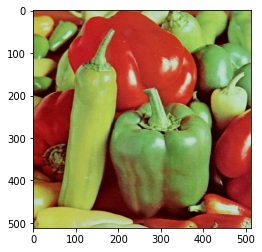

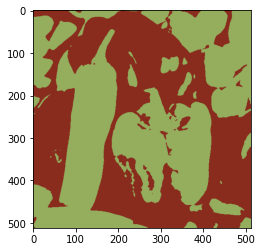

In [21]:
#Lemos a imaxe que queremos segmentar nun determiando numero de clusters
imagePath = "./imgs/peppers.jpg"
image = cv2.imread(imagePath)
if image is None:
    raise Exception("Non atopo a imaxe no sitio indicado")

#Visualizamos a imaxe orixinal    
plt.figure()
plt.imshow(image[:,:,::-1]);

#Facemos o cluster e visualizamos os resultados
#Indicamos que queremos dous clusters finais!
label,result= kmeans(image,segments=2)
plt.figure()
plt.imshow(result[:,:,::-1]);


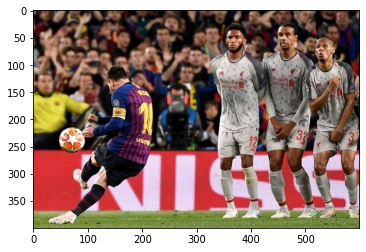

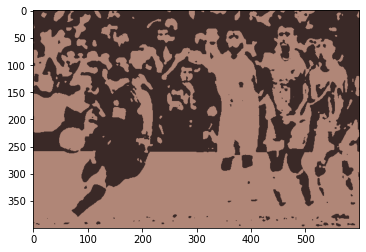

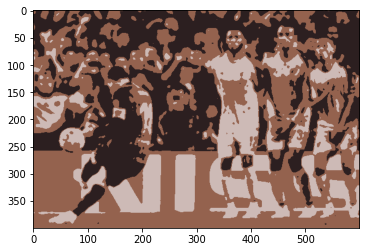

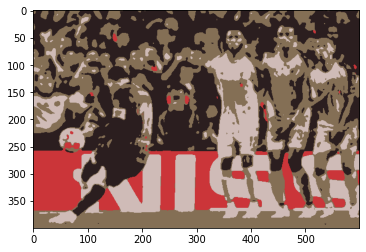

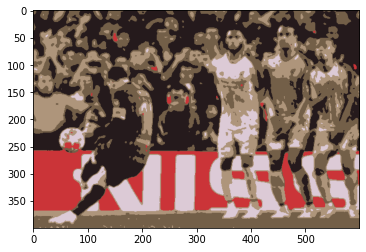

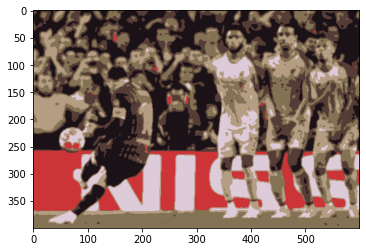

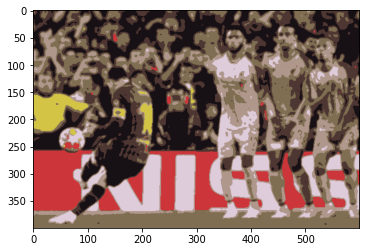

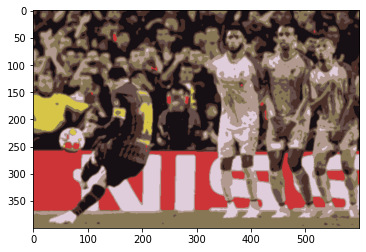

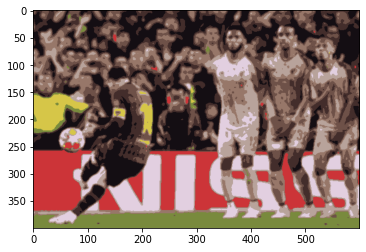

In [22]:
#Visualizamos os resultados de facer un clustering con
#disitinto numero final de clusters
imagePath = "./imgs/messi_liverpool.jpg"
image = cv2.imread(imagePath)
if image is None:
    raise Exception("Non atopo a imaxe no sitio indicado")

#Visualizamos a imaxe orixinal    
plt.figure()
plt.imshow(image[:,:,::-1]);


for i in range(2,10):
    #Facemos o cluster e visualizamos os resultados
    #Indicamos que queremos dous clusters finais!
    label,result= kmeans(image,segments=i)
    plt.figure()
    plt.imshow(result[:,:,::-1]);

## Número de clusters

### Segmentación como agrupación

Dependendo do que elixamos como *espazo de funcións*, podemos agrupar píxeles de diferentes xeitos

- Agrupación de píxeles en función da **semellanza de intensidade**

<br/>
<figure>
    <img src="imgs/L954.png" width=400/>
    <img src="imgs/L955.png" width=400/>
    <center><figcaption>Fig 4(a): Espazo de características: Valor de intensidade</figcaption></center>
</figure>

<br/>
<figure>
    <img src="imgs/L953.png" width=400/>
    <center><figcaption>Fig 4(b)</figcaption></center>
</figure>

Pódese considerar como unha ***cuantización*** do espazo de características-mapa de etiquetas

## Segmentación como agrupación


Dependendo do que elixamos como ***espazo de funcións***, podemos agrupar píxeles de diferentes xeitos.

Agrupación de píxeles en función da semellanza da <strong>cor</strong>.
<br/>
<figure>
    <img src="imgs/L956.png" width=400/>
    <center><figcaption>Fig 5(a): Espazo de características: valor da cor (3-d) </figcaption></center>
</figure>


A agrupación de K-means baseada na intensidade ou na cor é esencialmente a cuantificación vectorial dos atributos da imaxe
<br/>
<figure>
    <img src="imgs/L957.png" width=400/>
    <center><figcaption>Fig 5(b)</figcaption></center>
</figure>


Agrupación de píxeles en función da semellanza en ***intensidade+posición***

<br/>
<figure>
    <img src="imgs/L958.png" width=400/>
    <center><figcaption>Fig 5(c)</figcaption></center>
</figure>


Pódese combinar cor e localización...


<br/>
<figure>
    <img src="imgs/L959.png" width=400/>
    <center><figcaption>Fig 21(d)</figcaption></center>
</figure>



## Pros e Contras
 
- Pros
     - Método sinxelo
     - Converxe a un mínimo local da función error
- Contras
     - Intensivo en memoria
     - Hai que escoller K clusters
     - Sensible á inicialización
     - Sensible aos valores atípicos
     - Só atopa clusters "esféricos".

<br/>
<figure>
    <img src="imgs/L960.png" width=400/>
    <center><figcaption>Fig 6: Problema da esfericidade en k-means</figcaption></center>
</figure>    

### **<span style="color:green"><b><i>TAREA 1: Xogando con K-means</i></b></span>**

Escribe un programa que:
- aplique k-means a `messi_liverpool.jpg` con diferentes valores para $K$: $K=4$, $K=8$ e $K=16$, configurando `epsilon=0.2` e `it=10` como criterios de converxencia, e
- mostra, nun subplot $2\times2$, as 3 imaxes resultantes xunto coa de entrada.

In [ ]:

# Tarefa 1
matplotlib.rcParams['figure.figsize'] = (15.0, 12.0)

# Lemos a imaxe RGB
image = cv2.imread("imgs/messi_liverpool.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Aplanamos a imaxe
flattened_img = image.reshape((None,None))
flattened_img = np.float32(flattened_img)

# Establecemos os parámetros do k-means
it = None
epsilon = None
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, it, epsilon)

# Aplciamos k-means. Manten o terceiro argumento como None
_,label4,center4=cv2.kmeans(None,None,None,None,30,cv2.KMEANS_RANDOM_CENTERS)
_,label8,center8=cv2.kmeans(None,None,None,None,30,cv2.KMEANS_RANDOM_CENTERS)
_,label16,center16=cv2.kmeans(None,None,None,None,30,cv2.KMEANS_RANDOM_CENTERS)

# Etiquetas de cor resultantes
center4 = np.uint8(center4)
center8 = np.uint8(center8)
center16 = np.uint8(center16)

# Achamos o centro da cor (centro) asignado a cada pixel
res4 = center4[None]
res8 = center8[None]
res16 = center16[None]

# Voltamos as dimensions orixinais da imaxe
quantized4 = res4.reshape((image.shape))
quantized8 = res8.reshape((image.shape))
quantized16 = res16.reshape((image.shape))

# Visualizacion
plt.subplot(2,2,1)
plt.title("Imaxe oridinal")
plt.imshow(None)

#  k=4
plt.subplot(2,2,2)
plt.title("k=4")
plt.imshow(None)

#  k=8
plt.subplot(2,2,3)
plt.title("k=8")
plt.imshow(None)

#  k=16
plt.subplot(2,2,4)
plt.title("k=16")
plt.imshow(None);

### <font color="blue"><b><i>Reflexionando</i></b></font>

Agora, **responde ás seguintes preguntas**:

- Que está facendo `cv2.kmeans()` en cada iteración?

     <p style="margin: 4px 0px 6px 5px; color:blue"><i>A túa resposta aquí!</i></p>

- Que número máximo de iteracións utilizaches? Por que?
  
     <p style="margin: 4px 0px 6px 5px; color:blue"><i>A túa resposta aquí!</i></p>
    
- Como poderiamos comprimir estas imaxes para que requiran menos espazo en memoria? *Nota: considere que un píxel en RGB necesita 3 bytes para representarse, 8 bits por banda.*
  
     <p style="margin: 4px 0px 0px 5px; color:blue"><i>A túa resposta aquí!</i></p>

## 1.2.2 Maximización de expectativas (EM)

O algoritmo de maximización de expectativas (EM) é a xeneralización do algoritmo de K-means, onde cada grupo está representado por unha distribución gaussiana, parametrizada por unha media e unha matriz de covarianza, en lugar de só un centroide. É un clustering suave xa que non dá decisións difíciles de onde un píxel pertence ou non a un cluster, senón a probabilidade de que ese píxel pertenza a cada cluster $C_j$, é dicir, $p(x|C_j) \sim N(\mu_j,\Sigma_j)$. Isto implica que en cada iteración do algoritmo non só se refina a media de cada cluster (como nas K-medias), senón tamén as súas matrices de covarianza.

Antes de entrar en detalles sobre a teoría que hai detrás da EM, paga a pena ver como funciona no problema da placa do coche. OpenCV proporciona unha clase que implementa a funcionalidade necesaria para aplicar a segmentación EM a unha imaxe, chamada [`cv2.ml.EM()`](https://docs.opencv.org/3.4/d1/dfb/classcv_1_1ml_1_1EM.html). Todos os métodos e parámetros están completamente detallados na documentación, polo que é unha boa idea botarlle unha ollada.

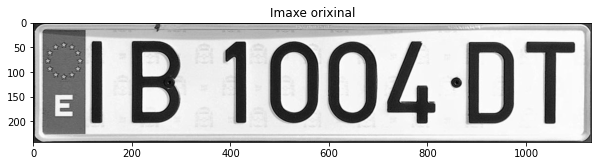

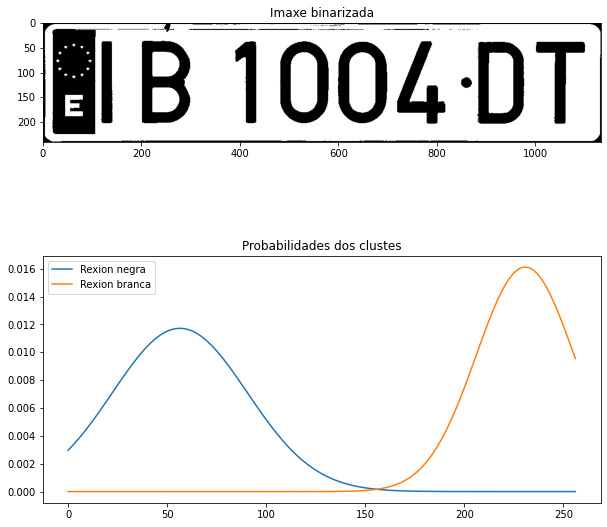

In [3]:
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
import scipy.stats as stats
cv2.setRNGSeed(5)

# Definimos parametros
n_clusters = 2 
covariance_type = 0 # 0: matriz de covarianza esferica. 1: matriz de covarianza diagonal. 2: matriz de covarianza xenerica
n_iter = 10
epsilon = 0.2

# Creamos un obxecto EM
em = cv2.ml.EM_create()

# Establecemos os seus parametros (para configurar o obxeco EM)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, n_iter, epsilon)
em.setClustersNumber(n_clusters)
em.setCovarianceMatrixType(covariance_type)
em.setTermCriteria(criteria)

# Lemos a imaxe da matricula
image = cv2.imread("./imgs/plate.jpg",0)
plt.title("Imaxe orixinal")
plt.imshow(image)
plt.show()

# linealizamos a imaxe
flattened_img = image.reshape((-1,1))
flattened_img = np.float32(flattened_img)

# Aplicamos EM
_, _, labels, _ = em.trainEM(flattened_img)

# Redimensionamos as etiquetas (labels) so tamanho da imaxe (binarization)
binarized = labels.reshape((image.shape))

# Visualizamoa a imaxe orixinal
plt.subplot(2,1,1)
plt.title("Imaxe binarizada")
plt.imshow(binarized, cmap="gray")

# --------------- Visualizacion de gaussinas ---------------

plt.subplot(2,1,2)
plt.title("Probabilidades dos clustes")

# achamos media e covs (para a imaxe de grises 1D )
means = em.getMeans()
covs = em.getCovs()

# Achamos a desvision tipica como un arrau numPy
sigmas = np.sqrt(covs)
sigmas = sigmas[:,0,0]

# pasamos de lista a array numPy
means = np.array(means)[:,0]

# Representamos as gaussianas
x = np.linspace(0, 256, 100)
plt.plot(x, stats.norm.pdf(x, loc = means[0], scale = sigmas[0]))
plt.plot(x, stats.norm.pdf(x, loc = means[1], scale = sigmas[1]))
plt.legend(['Rexion negra', 'Rexion branca'])

plt.show()

Como podes ver, aínda que en OpenCV k-means está implementado como método e EM como clase, funcionan dun xeito similar. No exemplo anterior, estamos segmentando unha matrícula de coche en dous grupos, e **cada grupo está definido por unha distribución gaussiana** (unha distribución gaussiana para a rexión negra e outra para a rexión branca). Esta é a base de EM, **pero como funciona**?

EM é un algoritmo iterativo que se divide en dous pasos principais:

- En primeiro lugar, **inicializa a matriz de media e covarianza de cada un dos clusters $K$**. Normalmente, escollid ao azar ($\mu_j$,$\Sigma_j$) e $P(C_j)$ (probabilidade previa) para cada grupo $j$.

- Despois, segue iterando facendo pasos de Expectación-Maximización ata que se cumpran algúns criterios de parada (por exemplo, cando non se produce ningún cambio nunha iteración completa):$\\[1pt]$

    1. **Paso de expectativa:** calcula as probabilidades de cada punto pertencente a cada cluster, é dicir $p(C_j|x_i), \forall i \in data$:
    $$P(C_j|x_i)=\frac{p(x_i|C_j)p(C_j)}{p(x_i)}=\frac{p(x_i|C_j)p(C_j)}{\sum_i P(x_i |C_j)p(C_j)}$$
    
    asigna $x_i$ ao cluster $C_j$ coa maior probabilidade $P(C_j|x_i)$.$\\[10pt]$
    
    2. **Paso de maximización:** volve a estimar os parámetros do cluster (($\mu_j$,$\Sigma_j$) e $p(C_j)$) para cada cluster $j$ coñecendo os resultados do paso esperado, que tamén é chamada *Estimación de máxima verosimilitud* (MLE):
$$\mu_j=\frac{\sum_i p(C_j|x_i)x_i}{\sum_i p(C_j|x_i)}$$ $\\[5pt]$
$$\sum_j = \frac{\sum_i p(C_j|x_i)(x_i-\mu_j)(x_i-\mu_j)^T}{\sum_i p(C_j|x_i)}$$$\\[5pt]$
$$p(C_j)=\sum_i p(C_j|x_i)p(x_i)=\frac{\sum_i p(C_j|x_i)}{N}$$

    Ten en conta que se non hai outra información dispoñible, os anteriores considéranse igualmente probables.
   
<center>
    <img src="./imgs/em.gif" width="400" align="center">
    <figcaption>Fig 4. Exemplo de execución do algoritmo EM con dous clusters, con detalles sobre a evolución das súas distribucións gaussianas asociadas.</figcaption>.
</center>$\\[5pt]$
   


Non che lembra o algoritmo K-means? **Cal é a diferenza entre eles?**

A principal diferenza é que K-means emprega a **distancia euclidiana** para medir a proximidade dun punto a un cúmulo. En EM usamos unha distancia na que **cada dimensión está ponderada** pola **matriz de covarianza** de cada grupo, que tamén se denomina **distancia Mahalanobis**. Ademais, para k-means que un punto de datos **pertence ou non** a un clúster, en EM un punto de datos ten unha **probabilidade** maior ou menor de pertencer a un clúster. A seguinte táboa resume outras diferenzas:

<table width="500px">
    <tr>
        <td style="text-align:center;"></td>
        <td style="text-align:center;"><b>K-means</b></td>
        <td style="text-align:center;"><b>EM</b></td>
    </tr>
    <tr>
        <td style="text-align:center;"><b>Representación de clusters</b></td>
        <td style="text-align:center;">Media</td>
        <td style="text-align:center;">Media, (co)variance</td>
    </tr>
    <tr>
        <td style="text-align:center;"><b>Inicialización de Clusters</b></td>
        <td style="text-align:center;">Aleatoriamene seleccionamos K means</td>
        <td style="text-align:center;">Inicialziamos K distribucións de Gaussianas <br /> ($\mu_j$,$\Sigma_j$) e $P(C_j)$</td>
    </tr>
    <tr>
        <td style="text-align:center;"><b>Expectación:</b> <br />
Estimate the cluster of each data</td>
        <td style="text-align:center;">Asignamos a cada punto a media mási próxima </td>
        <td style="text-align:center;">Cálcula $P(C_j|x_i)$</td>
    </tr>
    <tr>
        <td style="text-align:center;"><b>Maximización:</b> <br /> Re-estima os parámetros do cluster</td>
        <td style="text-align:center;">Acha as medias dos últimos clusters</td>
        <td style="text-align:center;">Calcula de novo para cada cluser $j$ a súa ($\mu_j,\Sigma_j$), $P(C_j)$  </td>
    </tr>
</table>

Se aínda tes curiosidade por EM, podes atopar [aquí](https://www.youtube.com/watch?v=REypj2sy_5U) unha explicación máis detallada.

#### <font color="red">pílula OpenCV</font>

Volvendo ao código, traballando con EM temos que especificar un tipo de matriz de covarianza usando [`em.setCovarianceMatrixType()`](https://docs.opencv.org/3.4/d1/dfb/classcv_1_1ml_1_1EM.html#a8b383c62697eac9a972931674790f6cd). Ademais, cando se aplica [`em.trainEM()`](https://docs.opencv.org/3.4/d1/dfb/classcv_1_1ml_1_1EM.html#a5a6a7badbc0c85a8c9fa50a41bf1bcd2) non devolve o centroide dos clusters, é posible facelos chamar [`em.getMeans()`](https://docs.opencv.org/3.4/d1/dfb/classcv_1_1ml_1_1EM.html#acec62dd55c06711c81d741c2d96603d1).

## Contexto do problema - Cuantificación da cor

<img src="./images/color-quantization.jpg" width="800"/>$\\[5pt]$

A cuantificación da cor é o proceso de reducir o número de cores distintas nunha imaxe conservando o máximo posible a súa aparencia de cor. Ten moitas aplicacións, como a compresión de imaxes (por exemplo, GIFs) ou [recuperación de imaxes baseada no contido](https://en.wikipedia.org/wiki/Content-based_image_retrieval).

Pódense usar técnicas de segmentación de imaxes para lograr a cuantificación de cores, imos ver como funciona!

### **<span style="color:green"><b><i>TAREFA 2: Cuantificación de cores con espazo YCrCb</i></b></span>**

No seguinte exemplo, a cuantificación da cor realízase usando o espazo de cor YCrCb en lugar de RGB. Lembra que tes máis información sobre este espazo dispoñible no cuaderno de Jupyter do Tema 2 (opencv_espazos_cor.ipynb). Deste xeito, a cuantificación só se aplica ás dúas bandas que portan esta inforamción Cr e Cb, descoidando a escala de grises da banda Y.

Ten en conta que, neste caso, o espazo de características ten dúas dimensións, unha para a banda Cr e outra para a Cb, de aí que o vector de características que describe o $i^{th}$ píxel resulta $x_i = [Cr_i,Cb_i]$ .

A ver como funciona!

**Que facer?** Proba e comprende o seguinte código.

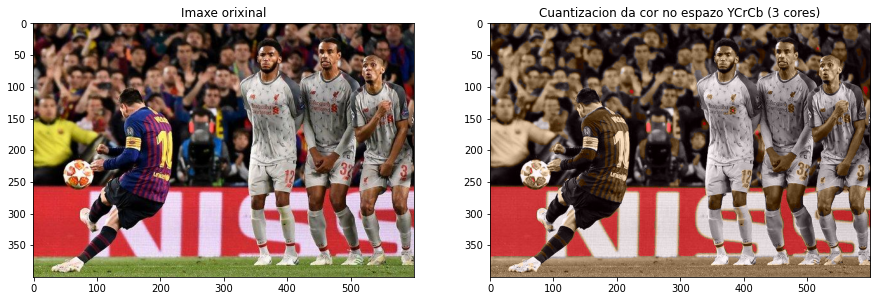

In [6]:
# Tarefa 2
matplotlib.rcParams['figure.figsize'] = (15.0, 15.0)
cv2.setRNGSeed(5)

# Definomos parametros

n_clusters = 3 # Numero de cores finais desexados

covariance_type = 1 # 0: matriz de covarianza esferica. 1: matriz de covarianza diagonal. 2: matriz de covarianza xenerica
n_iter = 10
epsilon = 0.2

# Creamos o obxecto EM baleiro
em = cv2.ml.EM_create()

# Inicializamos os parametros
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, n_iter, epsilon)
em.setClustersNumber(n_clusters)
em.setCovarianceMatrixType(covariance_type)
em.setTermCriteria(criteria)

# Lemos a imaxe de cor
image = cv2.imread("imgs/messi_liverpool.jpg")

# Convertemos a YCrCb
image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)

# Collemos as bandas de cor (2 ultimas)
color_bands = image[:,:,1:3]

# Aplanamos a imaxe
flattened_img = color_bands.reshape((-1,2))
flattened_img = np.float32(flattened_img)

# Aplicamos EM
_, _, labels, _ = em.trainEM(flattened_img)

# Etiquetas de cor resultantes
centers = em.getMeans()
centers = np.uint8(centers)
res = centers[labels.flatten()]

# Voltamos as dimensions orixinais da imaxe
color_bands = res.reshape((image.shape[0:2]) + (2,))

# Unimos a primeira banda Y (orixinal) coas dúas bandas cuantizadas
quantized = np.zeros(image.shape)
quantized[:,:,0] = image[:,:,0]
quantized[:,:,[1,2]] = color_bands

# forzamos o tip de dato a uint8
quantized = np.uint8(quantized)

# Retornamos a RGB
quantized_rgb = cv2.cvtColor(quantized, cv2.COLOR_YCrCb2RGB)
image_rgb = cv2.cvtColor(image, cv2.COLOR_YCrCb2RGB)

# Visualizamos
plt.subplot(1,2,1)
plt.title("Imaxe orixinal")
plt.imshow(image_rgb)

# Resultado
plt.subplot(1,2,2)
plt.title("Cuantizacion da cor no espazo YCrCb (3 cores)")
plt.imshow(quantized_rgb);

### Afondando nas matrices de covarianza

Hai 3 tipos de matrices de covarianza: **covarianzas esféricas**, **covarianzas diagonales** ou **covarianzas completas**: $\\[10pt]$

<centro>
<img src="./imgs/ellipses.png" width="700" align="center">
     <center><figcaption>Fig 6. Exemplos de diferentes tipos de matrices de covarianza.</figcaption></center>$\\[10pt]$
</centro>

### **<span style="color:green"><b><i>TAREA 3: Visualización de clústeres desde EM</i></b></span>**

A continuación, tes un código para visualizar os clústeres no espazo de cor YCrCb usando EM.

**Que facer?** Executa o exemplo anterior modificando o tipo de covarianza no algoritmo EM e visualiza os cambios usando o seguinte código.

In [8]:
#3 party: utilidade para debuxar elises. 

# This function draws a ellipse representing a Gaussian centered at x (mean) and with covariance P 
# This code has been adapted from the file DoVehicleGraphics.m by P.# Newman http://www.robots.ox.ac.uk/~pnewman

import numpy as np
from numpy.linalg import eig
from scipy.linalg import sqrtm
from matplotlib import patches
import matplotlib.pyplot as plt

def pltEllipse(fig, ax, mean, cov, scale=1, linewidth=.5, fill=False, **kwargs):
    mean = mean[0:2]
    cov = cov[0:2,0:2]                      # only plot x-y part
    
    if(not np.any(np.diag(cov)==0)):
        D,V = eig(cov)                      #V: eigenvectors, D: eigenvalues
        axes = V@sqrtm(np.diag(D))          # Axes of the ellipse, 2-by-2 matrix

        width = 2*scale*abs(axes[0,0]- axes[1,0])
        height = 2*scale*abs(axes[0,1]- axes[1,1])
        angle = np.arctan2(axes[1,0], axes[0,0])*180/np.pi
        h = ax.add_patch(patches.Ellipse((mean[0,0], mean[1,0]), 
                                       width, 
                                       height, 
                                       angle,
                                       linewidth=linewidth,
                                       fill=fill,
                                       **kwargs))
        return h

def PlotEllipse(fig, ax,mean, cov, scale=1, **kwargs):
    """This function draws a ellipse representing a Gaussian centered at x (mean) and with covariance P 
        This code has been adapted from the file DoVehicleGraphics.m by P.# Newman http://www.robots.ox.ac.uk/~pnewman
    
        Arguments:
        mean -- the center of the ellipse (i.e. the mean of the distribution) 
        cov -- the covariance matrix, of any dimension, but only the upper 2-by-2 submatrix is considered
        scale -- number of sigma we want to plot (scale factor). Default: 1
        **kwargs -- every remaining named parameter is passed to plt.plot(). We can pass 'color', 'linewidth' among others.
    """
    
    mean = mean[0:2]
    cov = cov[0:2,0:2]                      # only plot x-y part
    
    if(not np.any(np.diag(cov)==0)):
        D,V = eig(cov)                      #V: eigenvectors, D: eigenvalues
        
        y = (
            scale*
            np.vstack(
                (np.cos(np.arange(0.,(2*np.pi),0.1)),
                np.sin(np.arange(0.,(2*np.pi),0.1)))
                ))                          #Points of a circunference o radius nSigma
        
        axes = V@sqrtm(np.diag(D))          # Axes of the ellipse, 2-by-2 matrix
        el = axes@y                         # Points of the ellipse
        ei = np.vstack(el[:,0])
        el = np.concatenate((el,ei),axis=1) # To close the ellipse
        el += np.tile(mean,(1,el.shape[1])) # To translate it according to the robot pose
        
        res = ax.plot(el[0,:],el[1,:], **kwargs) #creates a line object and plot the ellipse
        return res


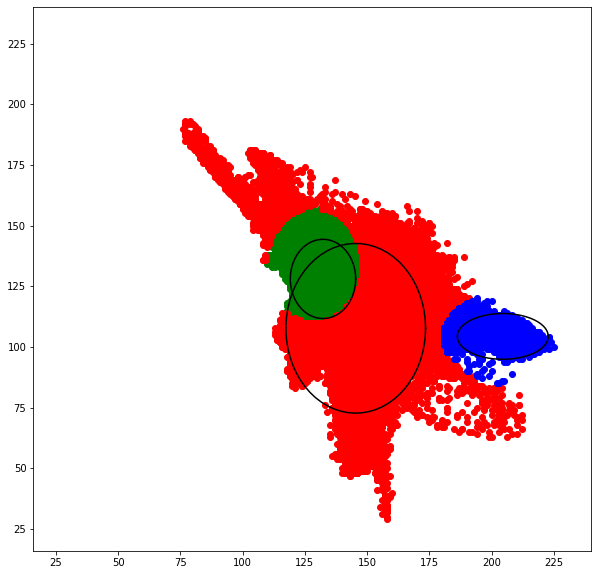

In [9]:
# TAREFA 3
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)

# Matries de medias (2D) e covarianzas (2x2)
means = np.array(em.getMeans())
covs = np.array(em.getCovs())

# Creamos a figura
fig, ax = plt.subplots()
plt.axis([16, 240, 16, 240])

# Conseguimos os puntos en cada cluster
cluster_1 = np.any(color_bands == np.unique(res,axis=0)[0,:],axis=2)
cluster_2 = np.any(color_bands == np.unique(res,axis=0)[1,:],axis=2)
cluster_3 = np.any(color_bands == np.unique(res,axis=0)[2,:],axis=2)
cluster_1 = image[cluster_1]
cluster_2 = image[cluster_2]
cluster_3 = image[cluster_3]

# Representamoslos
plt.plot(cluster_1[:,1],cluster_1[:,2],'go')
plt.plot(cluster_2[:,1],cluster_2[:,2],'ro')
plt.plot(cluster_3[:,1],cluster_3[:,2],'bo')

#Visualizamos as elipses que representan cada cluster
PlotEllipse(fig, ax, np.vstack(means[0,:]), covs[0,:,:], 2, color='black')
PlotEllipse(fig, ax, np.vstack(means[1,:]), covs[1,:,:], 2, color='black')
PlotEllipse(fig, ax, np.vstack(means[2,:]), covs[2,:,:], 2, color='black')

fig.canvas.draw()

### **<span style="color:green"><b><i>TAREA 4: Aplicar EM tendo en conta diferentes espazos de cor</i></b></span>**

É hora de mostrar o que aprendiches sobre **EM** e **espazos de cor**!

**Cal é a túa tarefa?** Pídese que **compares a cuantificación de cores nun espazo de cor RGB e nun espazo de cor YCrCb**.

Para iso:
- aplique EM a `messi_liverpool.jpg` usando 5 grupos (cores) tanto á imaxe no espazo RGB como á imaxe do espazo YCrCb,
- e mostra ambos os resultados xunto coa imaxe orixinal.

In [ ]:
# TAREFA 4
matplotlib.rcParams['figure.figsize'] = (15.0, 12.0)
cv2.setRNGSeed(5)

# Definimos parametros
n_clusters = 5
covariance_type = 2 # 0: matriz de covarianza esferica. 1: matriz de covarianza diagonal. 2: matriz de covarianza xenerica
n_iter = None
epsilon = None

# Creamos oobxecto EM baleiro
em = cv2.ml.EM_create()

# Parametros
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, n_iter, epsilon)

em.setClustersNumber(n_clusters)
em.setCovarianceMatrixType(covariance_type)
em.setTermCriteria(criteria)

# Lemos a imaxe de cor
image = cv2.imread("imgs/messi_liverpool.jpg")

# Convertemos a RGB
image_RGB = cv2.cvtColor(image, None)

# Convertemos a YCrCb
image_YCrCb = cv2.cvtColor(image, None)

# Aplanamos a imaxe RGB 
flattened_RGB = image_RGB.reshape((None,None))
flattened_RGB = np.float32(flattened_RGB)

#Aplanamos as bandas de cor YCrCb
color_bands_YCrCb = image_YCrCb[:,:,1:3]
flattened_YCrCb = color_bands_YCrCb.reshape((None,None))
flattened_YCrCb = np.float32(flattened_YCrCb)

#Aplicamos EM e conseguimos os centros dos clusters
_, _, labels_RGB, _ = em.trainEM(None)
centers_RGB = em.getMeans()
centers_RGB = np.uint8(centers_RGB)

_, _, labels_YCrCb, _ = em.trainEM(None)
centers_YCrCb = em.getMeans()
centers_YCrCb = np.uint8(centers_YCrCb)

# Etiquetas da cor resultantes
res_RGB = centers_RGB[labels_RGB.flatten()]
res_YCrCb = centers_YCrCb[labels_YCrCb.flatten()]

# Redimensionamos segundo a imaxe orixinal
quantized_RGB = res_RGB.reshape((image.shape))
quantized_colors_YCrCb = res_YCrCb.reshape((image.shape[0:2]) + (2,))

# Montamos de novo a imaxe coa banda de gris e as cuantizadas de cor no espazo YCrCb 
quantized_YCrCb = np.zeros(image.shape)
quantized_YCrCb[:,:,0] = image_YCrCb[:,:,0]
quantized_YCrCb[:,:,[1,2]] = quantized_colors_YCrCb

#Forzamos tipo de dato
quantized_YCrCb = np.uint8(quantized_YCrCb)

# Retornamos ao espazo RGB
quantized_YCrCb = cv2.cvtColor(quantized_YCrCb, cv2.COLOR_YCrCb2RGB)

# Visualizamos
plt.subplot(2,2,1)
plt.title("Imaxe orixinal")
plt.imshow(None)

# Cuantizada no espazo RGB
plt.subplot(2,2,2)
plt.title("Cuantizada no espazo RGB")
plt.imshow(None)

# Cuantizada no espazo  YCrCb 
plt.subplot(2,2,4)
plt.title("Cuantizada no espazo YCrCb")
plt.imshow(None);

## 1.2.3 Clustering espectral

SpectralClustering realiza unha redución da dimensionalidade da matriz de afinidade entre mostras, seguida da agrupación, por exemplo, mediante KMeans, dos compoñentes dos vectores propios no espazo de baixa dimensión. É especialmente eficiente computacionalmente se a matriz de afinidade é "sparse" e se usa o solucionador `amg` para o problema dos valores propios (teen en conta que o solucionador `amg` require que estea instalado o módulo `pyamg`).

A versión actual de SpectralClustering de sckit-image require que se **especifique previamente o número de clústeres**. Funciona ben para un número *reducido de clusters, pero non se recomenda para moitos clusters*.

Para dous clusters, SpectralClustering resolve unha relaxación convexa do problema de cortes normalizados no grafo de semellanza: cortando o grafo en dous para que o peso das arestas cortadas sexa pequeno en comparación cos pesos das que quedan dentro de cada cluster. Este criterio é especialmente interesante cando se traballa en imaxes, onde os vértices do gráfico son píxeles, e os pesos das arestas do grafo de semellanza son calculados mediante unha función do gradiente da imaxe.

Spectral clustering: kmeans, 7.74s
Spectral clustering: discretize, 5.19s


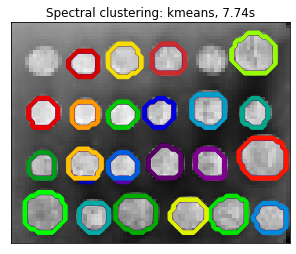

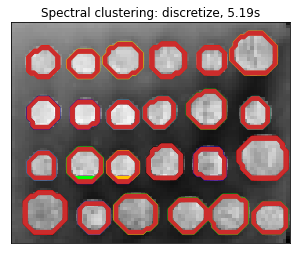

In [19]:
# Author: Gael Varoquaux <gael.varoquaux@normalesup.org>, Brian Cheung
# License: BSD 3 clause

import time

import numpy as np
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
import skimage
from skimage.data import coins
from skimage.transform import rescale

from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering
from sklearn.utils.fixes import parse_version

# these were introduced in skimage-0.14
if parse_version(skimage.__version__) >= parse_version("0.14"):
    rescale_params = {"anti_aliasing": False, "multichannel": False}
else:
    rescale_params = {}

# load the coins as a numpy array
orig_coins = coins()

# Resize it to 20% of the original size to speed up the processing
# Applying a Gaussian filter for smoothing prior to down-scaling
# reduces aliasing artifacts.
smoothened_coins = gaussian_filter(orig_coins, sigma=2)
rescaled_coins = rescale(smoothened_coins, 0.2, mode="reflect", **rescale_params)

# Convert the image into a graph with the value of the gradient on the
# edges.
graph = image.img_to_graph(rescaled_coins)

# Take a decreasing function of the gradient: an exponential
# The smaller beta is, the more independent the segmentation is of the
# actual image. For beta=1, the segmentation is close to a voronoi
beta = 10
eps = 1e-6
graph.data = np.exp(-beta * graph.data / graph.data.std()) + eps

# Apply spectral clustering (this step goes much faster if you have pyamg
# installed)
N_REGIONS = 25

for assign_labels in ("kmeans", "discretize"):
    t0 = time.time()
    labels = spectral_clustering(
        graph, n_clusters=N_REGIONS, assign_labels=assign_labels, random_state=42
    )
    t1 = time.time()
    labels = labels.reshape(rescaled_coins.shape)

    plt.figure(figsize=(5, 5))
    plt.imshow(rescaled_coins, cmap=plt.cm.gray)
    for l in range(N_REGIONS):
        plt.contour(labels == l, colors=[plt.cm.nipy_spectral(l / float(N_REGIONS))])
    plt.xticks(())
    plt.yticks(())
    title = "Spectral clustering: %s, %.2fs" % (assign_labels, (t1 - t0))
    print(title)
    plt.title(title)
plt.show()

## 1.2.4 Clustering xerárquico

A agrupación xerárquica é unha familia de algoritmos de agrupación que constrúen clústeres anidados fusionándoos ou dividíndoos sucesivamente. Esta xerarquía de clusters represéntase como unha árbore (ou dendrograma). A raíz da árbore é o único grupo que reúne todas as mostras, sendo as follas os racimos cunha única mostra. Para máis detalles cpnsulta [esta páxina](https://en.wikipedia.org/wiki/Hierarchical_clustering) da Wikipedia.

O obxectivo do AgglomerativeClustering é realizar unha agrupación xerárquica utilizando un enfoque de abaixo a arriba: cada observación comeza sendo o seu propio clúster e estes vanse unindo sucesivamente. Os criterios de vinculación determinan a métrica utilizada para a estratexia de fusión:

- **Ward** minimiza a suma das diferenzas ao cadrado dentro de todos os grupos. É un enfoque que minimiza a varianza e, neste sentido, é similar á función obxectivo k-means pero abordado cun enfoque xerárquico aglomerativo.
- A vinculación **máxima ou completa** minimiza a distancia máxima entre as observacións de pares de clusters.
- A vinculación **media** minimiza a media das distancias entre todas as observacións de pares de clusters.
- A conexión **única** minimiza a distancia entre as observacións máis próximas de pares de cúmulos.

Diferentes tipos de vinculación soportados por AgglomerativeClustering: vinculación Ward, completa, media e única¶

O clúster aglomerativo ten un comportamento do "rico que quere seguir enriquecéndose" que leva a tamaños de clúster desiguais. Neste sentido, o enlace único é a peor estratexia e Ward dá os tamaños máis regulares. Non obstante, a afinidade (ou a distancia empregada na agrupación) non se pode variar con Ward, polo que para as métricas non euclidianas, a vinculación media é unha boa alternativa. A vinculación única, aínda que non é robusta para os datos ruidosos, pódese calcular de forma moi eficiente e, polo tanto, pode ser útil para proporcionar agrupacións xerárquicas de conxuntos de datos máis grandes. A vinculación única tamén pode funcionar ben en datos non globulares. Na seguinte figura, ilústranse estes comportamentos:


<br/>
<figure>
    <img src="imgs/sphx_glr_plot_linkage_comparison_001.png" width=400/>
    <center><figcaption>Fig 7: Problema da esfericidade en k-means</figcaption></center>
</figure>  



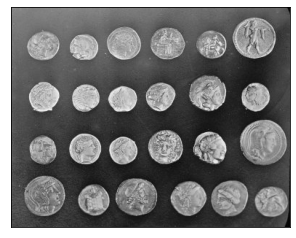

Compute structured hierarchical clustering...
Elapsed time:  0.22613787651062012
Number of pixels:  4697
Number of clusters:  27


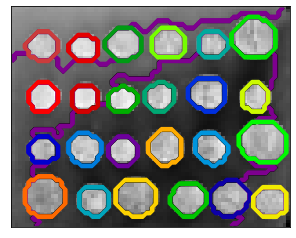

In [26]:
# Author : Vincent Michel, 2010
#          Alexandre Gramfort, 2011
# License: BSD 3 clause

import time as time

import numpy as np
from scipy.ndimage.filters import gaussian_filter

import matplotlib.pyplot as plt

import skimage
from skimage.data import coins
from skimage.transform import rescale

from sklearn.feature_extraction.image import grid_to_graph
from sklearn.cluster import AgglomerativeClustering
from sklearn.utils.fixes import parse_version

# these were introduced in skimage-0.14
if parse_version(skimage.__version__) >= parse_version("0.14"):
    rescale_params = {"anti_aliasing": False, "multichannel": False}
else:
    rescale_params = {}

# #############################################################################
# Generate data
orig_coins = coins()
plt.figure(figsize=(5, 5))
plt.imshow(orig_coins, cmap=plt.cm.gray)
plt.xticks(())
plt.yticks(())
plt.show()

# Resize it to 20% of the original size to speed up the processing
# Applying a Gaussian filter for smoothing prior to down-scaling
# reduces aliasing artifacts.
smoothened_coins = gaussian_filter(orig_coins, sigma=2)
rescaled_coins = rescale(smoothened_coins, 0.2, mode="reflect", **rescale_params)

X = np.reshape(rescaled_coins, (-1, 1))

# #############################################################################
# Define the structure A of the data. Pixels connected to their neighbors.
connectivity = grid_to_graph(*rescaled_coins.shape)

# #############################################################################
# Compute clustering
print("Compute structured hierarchical clustering...")
st = time.time()
n_clusters = 27  # number of regions
ward = AgglomerativeClustering(
    n_clusters=n_clusters, linkage="ward", connectivity=connectivity
)
ward.fit(X)
label = np.reshape(ward.labels_, rescaled_coins.shape)
print("Elapsed time: ", time.time() - st)
print("Number of pixels: ", label.size)
print("Number of clusters: ", np.unique(label).size)

# #############################################################################
# Plot the results on an image
plt.figure(figsize=(5, 5))
plt.imshow(rescaled_coins, cmap=plt.cm.gray)
for l in range(n_clusters):
    plt.contour(
        label == l,
        colors=[
            plt.cm.nipy_spectral(l / float(n_clusters)),
        ],
    )
plt.xticks(())
plt.yticks(())
plt.show()

## 1.2.5 Algortimo Mean Shift

O algoritmo de desprazamento medio busca **modos** ou máximos locais de densidade no espazo de características
<br/>
<figure>
    <img src="imgs/L961.png" width=400/>
    <img src="imgs/L962.png" width=200/>
    <center><figcaption>Fig 8</figcaption></center>
</figure>    

## Espazo Mean Shift 

<br/>
<figure>
    <img src="imgs/L963.gif" width=400/>
    <center><figcaption>Fig 9</figcaption></center>
</figure> 

## Clustering Mean Shift 


- Clúster: todos os puntos de datos da **conca de atracción** dun modo
- **Conca de atracción**: a rexión para a que todas as traxectorias conducen ao mesmo modo

<br/>
<figure>
    <img src="imgs/L964.png" width=400/>
    <img src="imgs/L965.png" width=400/>
    <center><figcaption>Fig 9(a)</figcaption></center>
</figure> 


- Atopar características (cor, gradientes, textura, etc.)
- Inicializa a xanela en puntos de características individuais (píxeles)
- Realizar un desprazamento medio para cada xanela (píxel) ata a converxencia
- Combina ventás (píxeles) que acaban preto do mesmo "pico" ou modo


<br/>
<figure>
    <img src="imgs/L966.png" width=400/>
    <center><figcaption>Fig 9(b)</figcaption></center>
</figure> 

## Resultados de segmentación do Mean Shift

<br/>
<figure>
    <img src="imgs/L967.png" width=400/>
    <img src="imgs/L968.png" width=400/>
    <img src="imgs/L969.png" width=400/>
    <center><figcaption>Fig 10</figcaption></center>
</figure>

In [41]:
## Precisas ter instalado o paquete pymeanshift. Executa este comando: pip install git+https://github.com/fjean/pymeanshift
import cv2
import pymeanshift as pms
matplotlib.rcParams['figure.figsize'] = (25.0, 25.0)

In [42]:
original_image = cv2.imread("./imgs/peppers.jpg")

In [43]:
segmented_image, labels_image, number_regions = pms.segment(original_image, spatial_radius=6, 
                                                              range_radius=4.5, min_density=50)

Numero de segmentos 910


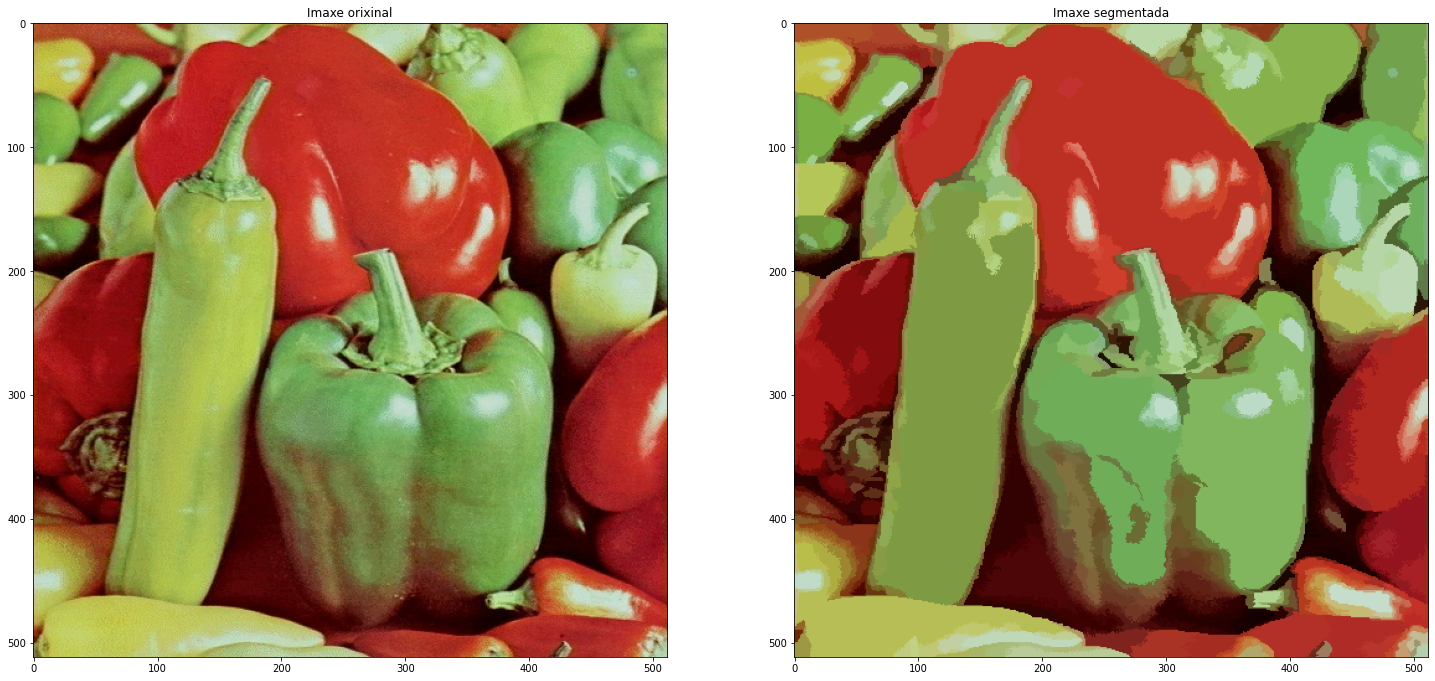

In [44]:
# Visualizamos
plt.subplot(1,2,1)
plt.title("Imaxe orixinal")
plt.imshow(original_image[:,:,::-1])

# Ssegmentada
plt.subplot(1,2,2)
plt.title("Imaxe segmentada")
plt.imshow(segmented_image[:,:,::-1]);

print("Numero de segmentos %d" % number_regions)

In [45]:
messi = cv2.imread("imgs/messi_liverpool.jpg")
segmented_messi, labels_image, number_regions = pms.segment(messi, spatial_radius=6, 
                                                              range_radius=4.5, min_density=50)

Numero de segmentos 1539


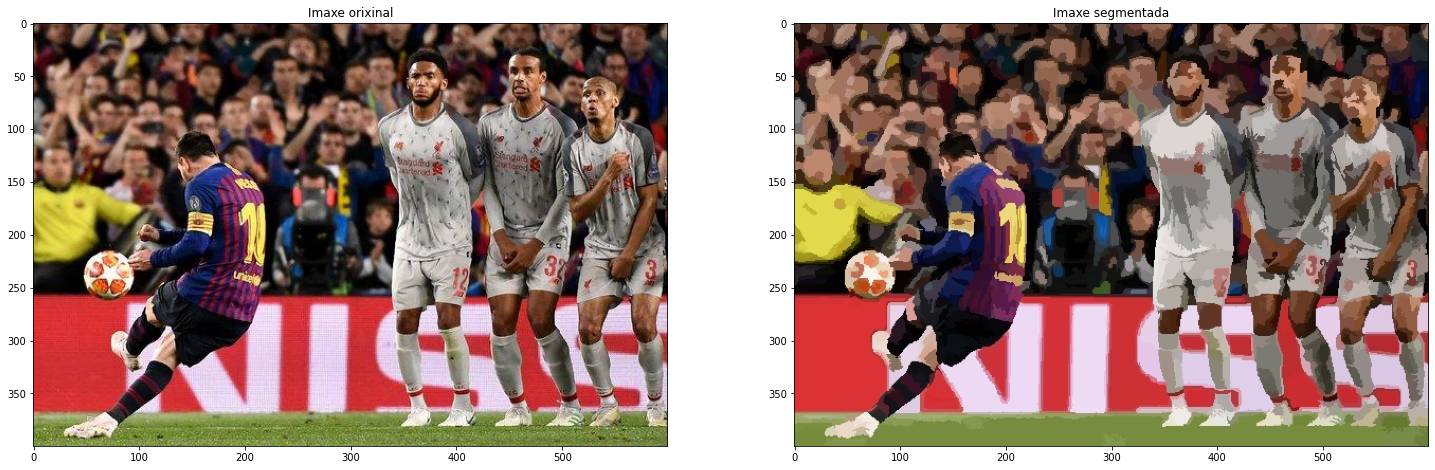

In [46]:


# Visualizamos
plt.subplot(1,2,1)
plt.title("Imaxe orixinal")
plt.imshow(messi[:,:,::-1])

# Ssegmentada
plt.subplot(1,2,2)
plt.title("Imaxe segmentada")
plt.imshow(segmented_messi[:,:,::-1]);

print("Numero de segmentos %d" % number_regions)





## Pros e contras

Pros:

- Busca automaticamente a cunca de atracción
- Unha opción de parámetro (tamaño da xanela)
- Non asume forma nos clusters
- Técnica xenérica
- Atopar múltiples modos


Contras:
- Selección do tamaño da xanela
- Non escala ben coa dimensión do espazo de características


## 1.3 Segmentación como agrupación
A cor, o brillo, a posición por si sos non son suficientes para distinguir todas as rexións...

<br/>
<figure>
    <img src="imgs/L970.png" width=400/>
    <center><figcaption>Fig 1(a)</figcaption></center>
</figure>

Agrupación de píxeles en función da semellanza de texturas

<br/>
<figure>
    <img src="imgs/L971.png" width=400/>
    <center><figcaption>Fig 11(b) Espazo de características: respostas do banco de filtros (e.g. 24D)</figcaption></center>
</figure>

### Exemplo de represemtación de texturas


<br/>
<figure>
    <img src="imgs/L972.png" width=400/>
    <center><figcaption>Fig 11(c)</figcaption></center>
</figure>

## Características de texturas

- Atopar "textons" agrupando vectores de saídas do banco de filtros
- Describe a textura nunha xanela baseándose no seu **histograma de textóns**

<br/>
<figure>
    <img src="imgs/L973.png" width=400/>
    <center><figcaption>Fig 12(a)</figcaption></center>
</figure>

<br/>
<figure>
    <img src="imgs/L974.png" width=400/>
    <center><figcaption>Fig 13(b)</figcaption></center>
</figure>

### Exemplos

<br/>
<figure>
    <img src="imgs/L975.png" width=400/>
    <center><figcaption>Fig 14(c)</figcaption></center>
</figure>

## Segmentación por partición de grafos


## Medida de afinidade


<br/>
<figure>
    <img src="imgs/L976.png" width=300/>
    <center><figcaption>Fig 13(a)</figcaption></center>
</figure>

Grafo totalmente conectado:

- 1 nodo (vértice) por cada píxel
- Unha aresta (ligazón) entre *cada par* de píxeles $\color{blue}{<}\color{green}{p}\color{blue}{\text{, }}\color{orange}{q}\color{blue}{>}$
- Peso de afinidade $\color{maroon}{W_{pq}}$ para cada ligazón (aresta)
    - $\color{maroon}{W_{pq}}$ mide a semellanza: inversamente proporcional á diferenza (en cor e posición...)
 

$$\color{blue}{\text{aff}(x_i,x_j) = exp \left ( -\frac{1}{2\sigma^2}dist(x_i,x_j)^2 \right ) }$$


<br/>
<figure>
    <img src="imgs/L977.png" width=300/>
    <center><figcaption>Fig 13(b)</figcaption></center>
</figure>

## Segmentación por partición de grafos

<br/>
<figure>
    <img src="imgs/L978.png" width=300/>
    <img src="imgs/L979.png" width=300/>
    <center><figcaption>Fig 13</figcaption></center>
</figure>

Dividir o grafo en segmentos

- Eliminar arestas que se cruzan entre segmentos
- O máis fácil de romper ligazóns con baixa afinidade

Resultados

- Os píxeles similares deben estar nos mesmos segmentos
- Os píxeles diferentes deben estar en segmentos diferentes


## 1.3.1 Graph Cut

$$\color{blue}{cut(A,B) = \sum_{p\in A,q\in B}w_{pq}}$$


- Conxunto de arestas cuxa eliminación fai desconectar un grafo

- Custo dun corte: Suma dos pesos das arestas cortadas

Un corte gráfico dános unha segmentación

- Cando un corte dun grafo "bo" e como o sabemos?


<br/>
<figure>
    <img src="imgs/L980.png" width=300/>
    <center><figcaption>Fig 14(a)</figcaption></center>
</figure>


Atopando un corte mínimo:

- Danos unha segmentación
- Existen algoritmos rápidos de corte mínimo (min-cut)

### corte mínimo (min-cut)

Problema co corte mínimo:

- Peso de corte proporcional ao número de arestas no corte
- Tende a producir compoñentes pequenos e illados

<br/>
<figure>
    <img src="imgs/L981.png" width=300/>
    <center><figcaption>Fig 14(b)</figcaption></center>
</figure>

## Corte normalizado

Corrixir o sesgo do corte mínimo normalizando polo tamaño dos segmentos:

$$\color{blue}{Ncut(A,B) = \frac{cut(A,B)}{assoc(A,V)} + \frac{cut(A,B)}{assoc(B,V)}}$$

$\color{blue}{assoc(A,V)}$ = suma dos pesos de todas as arestas que tocan A

Solución aproximada para minimizar o valor *Ncut*: *Problema de valores propios xeneralizados*

### Corte normalizado


- Sexa $\color{blue}{W}$ a matriz de adxacencia do grafo
- Sexa $\color{blue}{D}$ a matriz diagonal con entradas diagonais

$$\color{blue}{D(i,i) = \sum_jW(i,j)}$$

- Entón o custo de corte normalizado pódese escribir como: 

$$\color{blue}{\frac{y^T(D-W)y}{y^TDy}}$$

Onde $\color{blue}{y}$ é un vector indicador con 1 na posición $i^{th}$ se o punto característico $i^{th}$ pertence a A, en caso contrario, é unha constante negativa

### Algoritmo de corte normalizado

1. Representa a imaxe como un grafo pesado $\color{blue}{G = (V,E)}$, calcula o peso de cada aresta resumido en  $\color{blue}{D}$ e $\color{blue}{W}$

2. Resolve $\color{blue}{(D-W)y = \lambda Dy}$ para o segundo eigenvector co segundo eigenvalor máis pequeno

3. Usa as entradas do vector propio para biparticionar o gráfico

## Resultados


<br/>
<figure>
    <img src="imgs/L982.png" width=300/>
    <img src="imgs/L983.png" width=300/>
    <center><figcaption>Fig 15 Resultados de Segmentación</figcaption></center>
</figure>

O algoritmo GrabCut foi deseñado por Carsten Rother, Vladimir Kolmogorov e Andrew Blake de Microsoft Research Cambridge, no seu artigo, GrabCut": interactive foreground extraction using iterated graph cuts, deseñaron un algoritmo para a extracción de figuras de primeiro plano cunha mínima interacción do usuario, e o resultado foi GrabCut.


### <font style="color:rgb(8,133,37)">Sintaxe da función</font>

```python
mask, bgdModel, fgdModel	=	cv.grabCut(	img, mask, rect, bgdModel, fgdModel, iterCount[, mode]	)
```

**Parameters**
- **`img`**:	iamxe de entrada de tres canles
- **`mask`**:	Máscara monocanal de 8 bits de entrada/saída. A función inicializa a máscara cando o modo está configurado en GC_INIT_WITH_RECT. Os seus elementos poden ter unha das GrabCutClasses.
- **`rect`**:	ROI que contén un obxecto segmentado. Os píxeles fóra do ROI están marcados como "fondo obvio". O parámetro só se usa cando mode==GC_INIT_WITH_RECT .
- **`bgdModel`**:	Matriz temporal para o modelo de fondo. Non o modifiques mentres estás procesando a mesma imaxe.

- **`fgdModel`**:	Matrices temporais para o modelo en primeiro plano. Non o modifiques mentres estás procesando a mesma imaxe.
- **`iterCount`**:	Número de iteracións que debe facer o algoritmo antes de devolver o resultado. Teen en conta que o resultado pódese refinar con máis chamadas con mode==GC_INIT_WITH_MASK ou mode==GC_EVAL .
- **`mode`**:	Modo de operación que podería ser un dos GrabCutModes



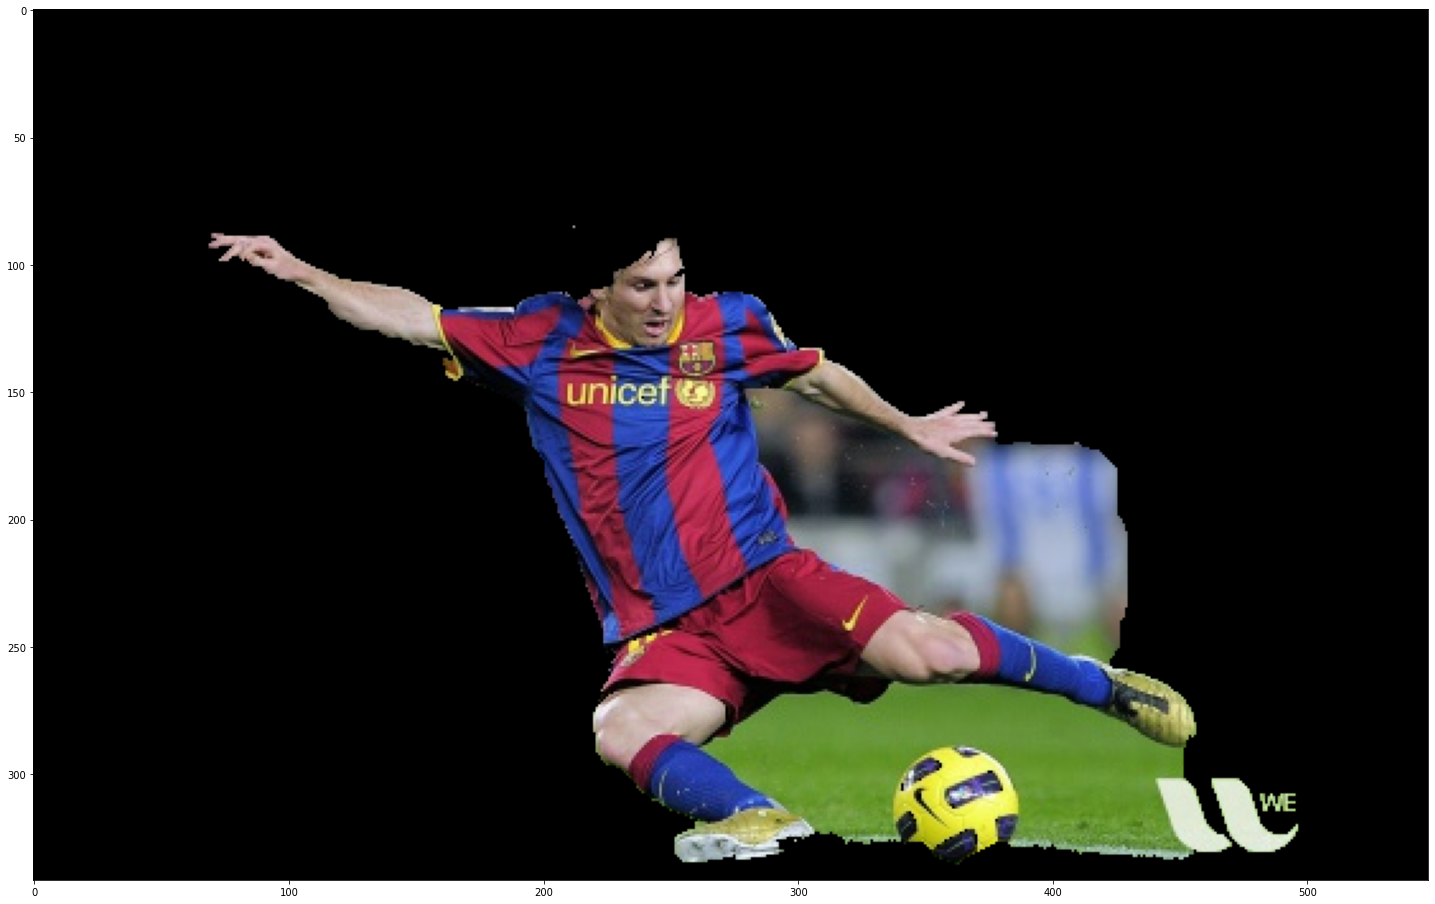

In [56]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img = cv2.imread('imgs/messi5.jpg')[:,:,::-1]
mask = np.zeros(img.shape[:2],np.uint8)

#modelos de fondo e primeiro plano
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

rect = (50,50,450,290)
cv2.grabCut(img,mask,rect,bgdModel,fgdModel,1,cv2.GC_INIT_WITH_RECT)

mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]

plt.imshow(img),plt.show();

## Pros e contras

Pros:

- Marco xenérico
     - Flexible á elección da función que calcula pesos ("afinidades") entre nodos
- Non require modelo de distribución de datos

Contras:

- A complexidade do tempo pode ser alta
     - Gráficos densos e moi conectados $\rightarrow$ moitos cálculos de afinidade
     - Resolución de problemas de valores propios
- Preferencia por particións equilibradas


### Extra

Utilizaches YCrCb neste caderno porque xa estabas familiarizado con el. A verdade é que, en materia de cuantificación de cores, úsase habitualmente [Espazo de cores CIELAB](https://en.wikipedia.org/wiki/CIELAB_color_space).

**responde ás seguintes preguntas**:

- Como funciona o espazo de cor do Lab?
- Por que se usa normalmente para a cuantificación de cores?
- Podes facer un script que compare a cuantización de cores neste espazo e con distintos metodos de clustering

## Conclusión

Parabéns por facer este traballo! Aprendeches:

- como funciona os clustering baseados em contornos activos e random walker
de k-means e como usalo,
- Como funcionan algoritmos de segmentación de rexións: K-means, EM, Mean-shift, espectral, aglomerativo e grafos.
- como realizar a cuantificación da cor e a importancia dos espazos de cor neste contexto, e
- Algúns conceptos básicos para a compresión de imaxes.